## Part 1 - Produce Data
We elected to use the datagen connector to generate fake data for this assignment. The topic we used was 'stocktrades. The steps were as follows:
*  Open a browser and go to http://localhost:9021/
*  Select the available cluster
*  On the menu bar, select Connect
*  Click on the connect-default cluster in the Connect Clusters list.
*  Click on Add connector
*  Select DatagenConnector
*  Enter connector_stock_trades in the Name field

Then:
Generate a data stream with following configurations:
```
{
  "name": "connector_stock_trades",
  "connector.class": "io.confluent.kafka.connect.datagen.DatagenConnector",
  "key.converter": "org.apache.kafka.connect.storage.StringConverter",
  "kafka.topic": "stocktrades",
  "max.interval": "100",
  "quickstart": "Stock_Trades"
}
```


## Part 2 - Using Ksql to create at least 2 streams with filtering from topics

To begin, you need to create a stream called stocktrades with no filtering in place.

### Create JSON Stream
In order for this to play nicely with spark, we need to mimic the raw stream as a json formatted stream.

### Stream 1 - Sell Stream
It may be in the interest of the business to view only streams where the stock was sold and not bought. This would be useful in identifying which shares should be taken as a 'short' position

### Stream 2 - Buy Stream
It may also be interesting to the business to see trades that were large buys.

### Table 1 - Aggregated Buy Trades


### Table 2 - Aggregated Sell Trades

## Part 3 - Consume/Transform data with Spark Streaming

In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StringType, StructField, IntegerType, FloatType, BinaryType

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
spark.version

'3.1.1'

In [4]:
spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()

'3.2.0'

## Building a Stream
The code below just walks through how the stream is built. A streamlined function is built for part 3a

In [5]:
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "STOCKTRADES_JSON") \
  .load()

In [6]:
stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [7]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrades_view") \
    .start()

In [10]:
clear_output(wait=True)
display(spark.sql('SELECT key, value FROM raw_stocktrades_view').show(20))
time.sleep(1)

+----+--------------------+
| key|               value|
+----+--------------------+
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
+----+--------------------+
only showing top 20 rows



None

In [11]:
raw_stream.stop()

### Convert Key Value pairs to strings

In [12]:
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
      .withColumn('value', stream_df["value"].cast(StringType()))

In [13]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrades_view") \
    .start()

In [15]:
clear_output(wait=True)
display(spark.sql('SELECT key, value FROM string_stocktrades_view').show(20))
time.sleep(1)

+----+--------------------+
| key|               value|
+----+--------------------+
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
+----+--------------------+
only showing top 20 rows



None

In [16]:
string_stream.stop()

## Transformation

In [17]:
schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
         StructField("USERID", StringType(), True)
])

In [18]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))

In [19]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- SIDE: string (nullable = true)
 |    |-- QUANTITY: integer (nullable = true)
 |    |-- PRICE: integer (nullable = true)
 |    |-- SYMBOL: string (nullable = true)
 |    |-- ACCOUNT: string (nullable = true)
 |    |-- USERID: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [20]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_stocktrades_view") \
    .start()

In [24]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_stocktrades_view').show(20, False))
time.sleep(1)

+----+----------------------------------------+----------------+---------+------+-----------------------+-------------+
|key |value                                   |topic           |partition|offset|timestamp              |timestampType|
+----+----------------------------------------+----------------+---------+------+-----------------------+-------------+
|null|{BUY, 1934, 893, ZTEST, ABC123, User_8} |STOCKTRADES_JSON|0        |0     |2021-06-11 00:40:34.802|0            |
|null|{SELL, 1401, 379, ZVV, ABC123, User_4}  |STOCKTRADES_JSON|0        |1     |2021-06-11 00:40:34.837|0            |
|null|{SELL, 2310, 848, ZJZZT, LMN456, User_6}|STOCKTRADES_JSON|0        |2     |2021-06-11 00:40:34.897|0            |
|null|{BUY, 35, 845, ZWZZT, LMN456, User_2}   |STOCKTRADES_JSON|0        |3     |2021-06-11 00:40:34.989|0            |
|null|{BUY, 3883, 503, ZBZX, ABC123, User_8}  |STOCKTRADES_JSON|0        |4     |2021-06-11 00:40:35.077|0            |
|null|{SELL, 2137, 88, ZWZZT, ABC123, Us

None

In [25]:
json_stream.stop()

### Flatten Data

In [26]:
stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )

In [27]:
stocktrades_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- side: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- account: string (nullable = true)
 |-- userid: string (nullable = true)



In [28]:
stocktrades_stream = stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrades_view") \
    .start()

In [32]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrades_view').show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    1934|  893| ZTEST| ABC123|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    1401|  379|   ZVV| ABC123|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    2310|  848| ZJZZT| LMN456|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|      35|  845| ZWZZT| LMN456|User_2|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    3883|  503|  ZBZX| ABC123|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    2137|   88| ZWZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    3459|   21|  ZBZX| XYZ789|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|     828|  253|  ZBZX| XYZ

None

In [33]:
stocktrades_stream.stop()

## Part 3a - Build at least 2 Spark Streaming dataframes
This function generates a stream from stocktrades with one line of code so its easier to call in later components

In [34]:
def generate_stocktrades_stream(keep_stream = False):
    
    # Define the raw Spark Stream
    stream_df = spark \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("startingOffsets", "latest") \
      .option("subscribe", "STOCKTRADES_JSON") \
      .load()
    
    # Convert to string types for JSON conversion
    string_stream_df = stream_df \
        .withColumn("key", stream_df["key"].cast(StringType())) \
        .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema for the end JSON format
    schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
        StructField("USERID", StringType(), True)
])
    # Convert the string type to json format stream
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    
    # Export a queryable view od the stream
    
    if not keep_stream:
        return stocktrades_stream_df \
        .writeStream \
        .format("memory") \
        .queryName("stocktrades_view") \
        .start()
    else:
        return stocktrades_stream_df \
        .writeStream \
        .format("memory") \
        .queryName("stocktrades_view") \
        .start(), stocktrades_stream_df

In [35]:
stocktrades_stream = generate_stocktrades_stream()

In [36]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrades_view').show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...|SELL|    3942|  526| ZWZZT| ABC123|User_3|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...| BUY|    1798|  760| ZWZZT| ABC123|User_7|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...|SELL|    2206|  710| ZWZZT| ABC123|User_1|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...| BUY|     853|  837| ZWZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...|SELL|     259|  855| ZXZZT| XYZ789|User_1|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...| BUY|     427|  193| ZJZZT| ABC123|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...| BUY|    2598|  376| ZJZZT| ABC123|User_3|
|     null|STOCKTRADES_JSON|2021-06-11 01:53:...|SELL|    2925|  265|   ZVV| LMN

None

In [37]:
stocktrades_stream.stop()

### Second Query

In [38]:
# Create function to stream filtered streams from Kafka as streaming dataframes
def generate_side_stream(SIDE):
    
    # Create string for source
    source_stream = SIDE + "_TRADES"
    # Define the raw Spark Stream
    
    stream_df = spark \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("startingOffsets", "latest") \
      .option("subscribe", source_stream) \
      .load()
    
    # Convert to string types for JSON conversion
    string_stream_df = stream_df \
        .withColumn("key", stream_df["key"].cast(StringType())) \
        .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema for the end JSON format
    schema_stocktrades =  StructType([
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
        StructField("USERID", StringType(), True)
])
    # Convert the string type to json format stream
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    
    # Export a queryable view od the stream
    return stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName(SIDE + '_view') \
    .start()

In [39]:
# Create views of the buy and sell streams
BUY_stream = generate_side_stream('BUY')
SELL_stream = generate_side_stream('SELL')

In [40]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql('SELECT * FROM BUY_view').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------+-----+------+-------+------+
|event_key|event_topic|     event_timestamp|quantity|price|symbol|account|userid|
+---------+-----------+--------------------+--------+-----+------+-------+------+
|     null| BUY_TRADES|2021-06-11 01:53:...|    3940|  150|   ZVV| ABC123|User_5|
|     null| BUY_TRADES|2021-06-11 01:53:...|    4306|  258|  ZBZX| ABC123|User_8|
+---------+-----------+--------------------+--------+-----+------+-------+------+



None

In [41]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql('SELECT * FROM SELL_view').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------+-----+------+-------+------+
|event_key|event_topic|     event_timestamp|quantity|price|symbol|account|userid|
+---------+-----------+--------------------+--------+-----+------+-------+------+
|     null|SELL_TRADES|2021-06-11 01:53:...|    2921|  803| ZXZZT| ABC123|User_2|
|     null|SELL_TRADES|2021-06-11 01:53:...|    4571|  218| ZVZZT| XYZ789|User_7|
|     null|SELL_TRADES|2021-06-11 01:53:...|     403|  584| ZXZZT| LMN456|User_3|
|     null|SELL_TRADES|2021-06-11 01:53:...|    4932|  382| ZWZZT| XYZ789|User_1|
|     null|SELL_TRADES|2021-06-11 01:53:...|    4435|  877|  ZBZX| ABC123|User_1|
|     null|SELL_TRADES|2021-06-11 01:53:...|     328|  401|   ZVV| LMN456|User_8|
|     null|SELL_TRADES|2021-06-11 01:53:...|    1982|  645| ZXZZT| LMN456|User_2|
|     null|SELL_TRADES|2021-06-11 01:53:...|    4497|  254| ZXZZT| LMN456|User_5|
|     null|SELL_TRADES|2021-06-11 01:53:...|    2290|  920|   ZVV| XYZ789|User_7|
|     null|SELL_

None

In [42]:
# Stop the two streams
BUY_stream.stop()
SELL_stream.stop()

## Part 3b - Build 1 window stream with a watermark

In [43]:
# Restart the raw data data frame
raw_stream, raw_stream_df = generate_stocktrades_stream(True)

# Create parameters for the window stream
window_duration = '60 seconds'
slide_duration = '10 seconds'
time.sleep(10)

In [44]:
# Create the windowed stream (this groups by symbol and then counts the numbers of trades in the window, quantity of shares traded and the average price traded)
windowed_agg_df = raw_stream_df \
    .withWatermark('event_timestamp', '1 minutes') \
    .groupBy(F.window(raw_stream_df.event_timestamp, window_duration, slide_duration), raw_stream_df.symbol) \
    .agg(F.count('SYMBOL').alias('no_trades'), \
    F.sum('QUANTITY').alias('tot_quantity'), \
    F.avg('PRICE').alias('avg_price') \
     )

In [45]:
# Export the stream as a qeuryable view
windowed_agg_stream = windowed_agg_df \
                        .writeStream \
                        .format("memory") \
                        .outputMode("Complete") \
                        .queryName("windowed_view") \
                        .start()

In [47]:
while True:
    clear_output(wait=True)
    display(spark.sql('SELECT * FROM windowed_view').show())
    time.sleep(1)

KeyboardInterrupt: 

In [48]:
raw_stream.stop()

In [65]:
windowed_agg_stream.stop()

## Part 3c - Build at least 1 spark query

In [ ]:
stocktrade_stream_df = generate_stocktrades_stream()

In [ ]:
query = "select * from stocktrades_view WHERE price > 800"

In [ ]:
# Show results (limit 20) of stream
clear_output(wait=True)
= spark.sql('SELECT * FROM BUY_view')
time.sleep(1)

## Part 3d - Export your spark queries into parquetsstocktrade_stream

In [6]:
stocktrade_stream_df = generate_stocktrades_stream()


In [7]:
stocktrade_stream_df.writeStream \
    .format("parquet") \
    .option("header", True) \
    .option("path", "big_data_eng/bde_lab_8/") \
    .option("checkpointLocation", "checkpoint/data") \
    .outputMode("append") \
    .start()

AttributeError: 'StreamingQuery' object has no attribute 'writeStream'

In [19]:
stocktrade_stream_df.stop()

## Part 3e - build at least 1 visualisation which will be refreshed at regular interval

In [109]:
import matplotlib.pyplot as plt


In [119]:
BUY_stream = generate_side_stream('BUY')

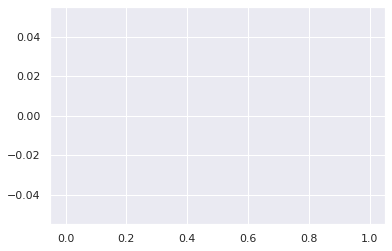

KeyboardInterrupt: 

In [120]:
while True:
    clear_output(wait=True)
    df = spark.sql('SELECT quantity,price, symbol FROM BUY_view WHERE price > 1000').toPandas()
    plt.hist(df['quantity'] )
    plt.pause(5)
   

In [118]:
BUY_stream.stop()